In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import random
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision
from torchvision import datasets, models, transforms, utils
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm
import albumentations as aug
from albumentations import (HorizontalFlip, VerticalFlip, Normalize, Resize, Rotate, Compose)
from albumentations.pytorch import ToTensor
from ranger import Ranger
from clustering_utils import ClusterNet5g, IID_loss, provider
plt.ion()

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(43)

In [38]:
num_epochs = 8
lr = 1e-5
num_sub_heads = 5
num_classes = 2
net = ClusterNet5g(num_sub_heads, num_classes)
optimiser = Ranger(net.parameters(),lr=lr)
scheduler = ReduceLROnPlateau(optimiser,factor=0.5, mode="min", patience=5, verbose=True,min_lr = 1e-5)
net.cuda()
net = torch.nn.DataParallel(net)
net.train()
batch_sz = 8
input_sz = 420
dataloaders = [provider(shape = input_sz, batch_size=batch_sz),provider(shape = input_sz, batch_size=batch_sz)]
num_dataloaders = len(dataloaders)-1
lamb = 1.1

In [39]:
def train():
    epoch_loss = []
    epoch_loss_no_lamb = []
    tk0 = tqdm(range(num_epochs), total=num_epochs)
    for e_i in tk0:

      iterators = (d for d in dataloaders)

      b_i = 0

      avg_loss = 0.
      avg_loss_no_lamb = 0.
      avg_loss_count = 0

      for tup in zip(*iterators):
        net.zero_grad()

        all_imgs = torch.zeros(batch_sz, 1,
                               input_sz//2,
                               input_sz//2).cuda()
        all_imgs_tf = torch.zeros(batch_sz, 1,
                                  input_sz//2,
                                  input_sz//2).cuda()

        imgs_curr = tup[0][0]  # always the first
        curr_batch_sz = imgs_curr.size(0)
        for d_i in range(num_dataloaders):
          imgs_tf_curr = tup[1 + d_i][0]  # from 2nd to last
          assert (curr_batch_sz == imgs_tf_curr.size(0))

          actual_batch_start = d_i * curr_batch_sz
          actual_batch_end = actual_batch_start + curr_batch_sz
          all_imgs[actual_batch_start:actual_batch_end, :, :, :] = \
            imgs_curr.cuda()
          all_imgs_tf[actual_batch_start:actual_batch_end, :, :, :] = \
            imgs_tf_curr.cuda()

        curr_total_batch_sz = curr_batch_sz * num_dataloaders  # times 2
        all_imgs = all_imgs[:curr_total_batch_sz, :, :, :]
        all_imgs_tf = all_imgs_tf[:curr_total_batch_sz, :, :, :]

        x_outs = net(all_imgs)
        x_tf_outs = net(all_imgs_tf)

        avg_loss_batch = None  # avg over the heads
        avg_loss_no_lamb_batch = None
        for i in range(num_sub_heads):
          loss, loss_no_lamb = IID_loss(x_outs[i], x_tf_outs[i], lamb=lamb)
          if avg_loss_batch is None:
            avg_loss_batch = loss
            avg_loss_no_lamb_batch = loss_no_lamb
          else:
            avg_loss_batch += loss
            avg_loss_no_lamb_batch += loss_no_lamb

        avg_loss_batch /= num_sub_heads
        avg_loss_no_lamb_batch /= num_sub_heads

        if not np.isfinite(avg_loss_batch.item()):
          print("Loss is not finite... %s:" % str(avg_loss_batch))
          exit(1)

        avg_loss += avg_loss_batch.item()
        avg_loss_no_lamb += avg_loss_no_lamb_batch.item()
        avg_loss_count += 1

        avg_loss_batch.backward()

        optimiser.step()

        b_i += 1
      avg_loss = float(avg_loss / avg_loss_count)
      avg_loss_no_lamb = float(avg_loss_no_lamb / avg_loss_count)
#       scheduler.step(avg_loss)
      tk0.set_postfix(loss = avg_loss, loss_nolamb = avg_loss_no_lamb)
      epoch_loss.append(avg_loss)
      epoch_loss_no_lamb.append(avg_loss_no_lamb)
      torch.cuda.empty_cache()
    
    return epoch_loss
epoch_loss = train()

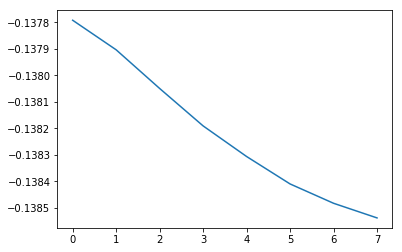

In [40]:
plt.plot(np.arange(0,num_epochs,1),epoch_loss)
plt.show()

In [41]:
test_data = provider(batch_size=1, train = False)

In [42]:
net.eval()
preds = []
for i, img in enumerate(test_data):
#     plt.imshow(img[0,0,...],cmap = 'gray')
#     plt.show()
    img = img.cuda()
    outs = net(img)
    final_out  = 0
    for out in outs:
        final_out+=out.detach().cpu().numpy()
    classes = final_out.argmax(axis = 1)
    for classs in classes:
        preds.append(classs)
    torch.cuda.empty_cache()
#     print(classs)
pd.Series(preds).value_counts()

1    215
dtype: int64

In [43]:
pd.Series(preds[:105]).value_counts()

1    105
dtype: int64

In [44]:
pd.Series(preds[105:]).value_counts()

1    110
dtype: int64

In [9]:
#Rsults - 
num_epochs = 20
lr = 1e-5
num_sub_heads = 5
num_classes = 3
'''
lambda-2.0

0    105
1     61
2     49

0    60
2    23
1    22

0    45
1    39
2    26

lambda-1.5

1    97
2    85
0    33

2    50
1    38
0    17

1    59
2    35
0    16

lambda-1.2

0    84
2    79
1    52

2    48
0    35
1    22

0    49
2    31
1    30

lambda-1.1

2    88
0    70
1    57

0    43
2    38
1    24

2    50
1    33
0    27

lambda-1.01

0    89
2    85
1    41

0    44
2    36
1    25

2    49
0    45
1    16

lambda-1.001

0    119
2     66
1     30

0    49
2    43
1    13

0    70
2    23
1    17
'''

'\nlambda-2.0\n\n0    105\n1     61\n2     49\n\n0    60\n2    23\n1    22\n\n0    45\n1    39\n2    26\n\nlambda-1.5\n\n1    97\n2    85\n0    33\n\n2    50\n1    38\n0    17\n\n1    59\n2    35\n0    16\n\nlambda-1.2\n\n0    84\n2    79\n1    52\n\n2    48\n0    35\n1    22\n\n0    49\n2    31\n1    30\n\nlambda-1.1\n\n2    88\n0    70\n1    57\n\n0    43\n2    38\n1    24\n\n2    50\n1    33\n0    27\n\nlambda-1.01\n\n0    89\n2    85\n1    41\n\n0    44\n2    36\n1    25\n\n2    49\n0    45\n1    16\n\nlambda-1.001\n\n0    119\n2     66\n1     30\n\n0    49\n2    43\n1    13\n\n0    70\n2    23\n1    17\n'